In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy as sq 
import psycopg2

In [4]:
host = 'localhost'
port = '5432'
user = 'postgres'
password = '6'
db = 'postgres'
conn = psycopg2.connect(host=host, port=port, user=user, password=password, dbname=db)
connection_string = f"postgresql://{user}:{password}@{host}/{db}"

engine = sq.create_engine(connection_string)

In [5]:
from sqlalchemy import create_engine, text

connection_string = f"postgresql://{user}:{password}@{host}:{port}/{db}"
engine = create_engine(connection_string)

with engine.connect() as conn:
    delete_sql_1 = text("""
    DELETE FROM adele_songs_data
    WHERE track_name ILIKE '%Live%'
    """)
    delete_sql_2 = text("""
    DELETE FROM adele_songs_data
    WHERE track_name = 'Many Shades Of Black - Performed by The Raconteurs and Adele'
    """)
    conn.execute(delete_sql_1)
    conn.execute(delete_sql_2)

select_sql = """
SELECT album_name,
       track_name,
       track_id,
       release_date,
       popularity,
       duration_ms,
       (duration_ms / 60000) AS duration_minutes,
       danceability,
       energy,
       key,
       loudness,
       mode,
       speechiness,
       valence,
       track_url,
       album_cover_url
FROM adele_songs_data
ORDER BY album_name
"""
df = pd.read_sql(select_sql, engine)

### Analyzing Song Popularity Based on Word in Title

In this section, we analyze the impact of a specific word in the song title on the song's popularity.

- **Function Definition**: We define a function `contains_word` that checks whether a given word is present in the song title.
- **Word Input**: The user inputs a word to check for in the song titles.
- **New Column**: We create a new column `contains_word_in_title` to mark whether each song contains the input word in its title.
- **Popularity Comparison**: The code calculates the average popularity for songs with and without the word in their titles.
- **Result**: The average popularity for both categories (songs with and without the word) is printed.

This analysis helps to identify whether the presence of a specific word in the title correlates with higher or lower song popularity.


In [7]:
def contains_word(title, word):
    return word.lower() in title.lower()
word_to_check = input("Enter a word to check: ")

df['contains_word_in_title'] = df['track_name'].apply(lambda x: contains_word(x, word_to_check))

mean_pop_with_word = df[df['contains_word_in_title']]['popularity'].mean()
mean_pop_without_word = df[~df['contains_word_in_title']]['popularity'].mean()
print(f"Средняя популярность песен с словом '{word_to_check}' в названии: {mean_pop_with_word}")
print(f"Средняя популярность песен без слова '{word_to_check}' в названии: {mean_pop_without_word}")
categories = ['With Word', 'Without Word']
values = [mean_pop_with_word, mean_pop_without_word]

Средняя популярность песен с словом 'love' в названии: 59.25
Средняя популярность песен без слова 'love' в названии: 60.526315789473685


### Visualizing Average Popularity of Songs

In this section, we create a bar chart to visualize the average popularity of Adele's songs.

- **Data Grouping**: We group the dataset by the song's title (`track_name`) and calculate the average popularity for each song.
- **Bar Chart Plot**: A bar chart is generated to display the average popularity of each song, which allows us to visually compare the popularity of different tracks over time.
- **Axis Labels and Title**: The chart is labeled with the song titles on the x-axis, popularity on the y-axis, and a title that summarizes the plot.

This visualization provides insight into which songs were the most popular and how they compare to each other.


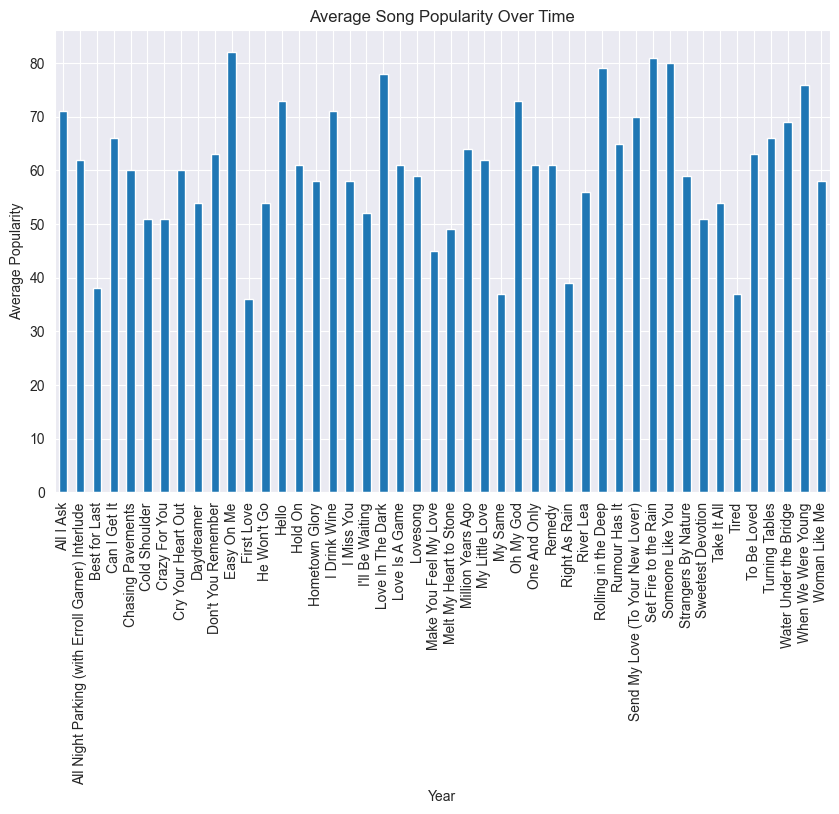

In [8]:
popularity_by_song = df.groupby('track_name')['popularity'].mean()
plt.figure(figsize=(10, 6))
popularity_by_song.plot(kind='bar')
plt.title('Average Song Popularity Over Time')
plt.xlabel('Year')
plt.ylabel('Average Popularity');


### Album Performance Analysis

In this section, we analyze the performance of Adele's albums based on three key metrics: popularity, energy, and danceability.

- **Data Type Conversion**: We ensure that the `album_name` column is treated as a string for consistent grouping.
- **Album Performance Calculation**: We group the dataset by `album_name` and calculate the mean values for popularity, energy, and danceability for each album.
- **Aggregated Data**: The result is a table where each row represents an album, showing the average values for the three metrics.
- **Insight**: This analysis helps us compare how different albums performed in terms of popularity and musical characteristics like energy and danceability.

The output provides a summary of Adele's albums and their average performance across these metrics.


In [9]:
df['album_name'] = df['album_name'].astype(str)

album_performance = df.groupby('album_name').agg({
    'popularity': 'mean',
    'energy': 'mean',
    'danceability': 'mean'
}).reset_index()

print(album_performance)

  album_name  popularity    energy  danceability
0         19   46.250000  0.399333      0.629083
1         21   64.909091  0.534000      0.580273
2         25   66.090909  0.500091      0.496455
3         30   64.833333  0.482667      0.506583


### Correlation Analysis of Audio Features

In this section, we calculate the correlation between key audio features in Adele's songs.

- **Selected Features**: We focus on five features: danceability, energy, popularity, loudness, and valence.
- **Correlation Matrix**: The code generates a correlation matrix, which shows the strength and direction of the relationships between these features. Correlation values range from -1 to 1:
  - A value close to 1 indicates a strong positive correlation.
  - A value close to -1 indicates a strong negative correlation.
  - A value near 0 suggests little to no correlation.
  
- **Insight**: This matrix helps us understand how these musical characteristics and popularity relate to one another. For example, we might explore whether songs with higher energy tend to have higher popularity.

This analysis is useful for identifying potential relationships between the features.


In [6]:
correlation_matrix = df[['danceability', 'energy', 'popularity', 'loudness', 'valence']].corr()

print(correlation_matrix)


              danceability    energy  popularity  loudness   valence
danceability      1.000000  0.174025   -0.192015 -0.138302  0.616419
energy            0.174025  1.000000    0.119345  0.726161  0.513264
popularity       -0.192015  0.119345    1.000000  0.370097 -0.283582
loudness         -0.138302  0.726161    0.370097  1.000000  0.198257
valence           0.616419  0.513264   -0.283582  0.198257  1.000000


### K-Means Clustering on Audio Features

In this section, we apply K-Means clustering to group Adele's songs based on key audio features.

- **Selected Features**: We choose four audio features—danceability, energy, loudness, and valence—for clustering.
- **K-Means Algorithm**: We apply the K-Means algorithm with 3 clusters, which groups the songs into three distinct clusters based on similarities in their audio features.
- **Cluster Assignment**: Each song is assigned to a cluster, and this information is stored in a new column called `cluster`.
- **Pair Plot Visualization**: We use a Seaborn pair plot to visualize the distribution of the features across the three clusters. Each point is color-coded according to its cluster assignment.

This clustering helps identify patterns or common characteristics in Adele's songs, revealing which tracks share similar musical attributes.


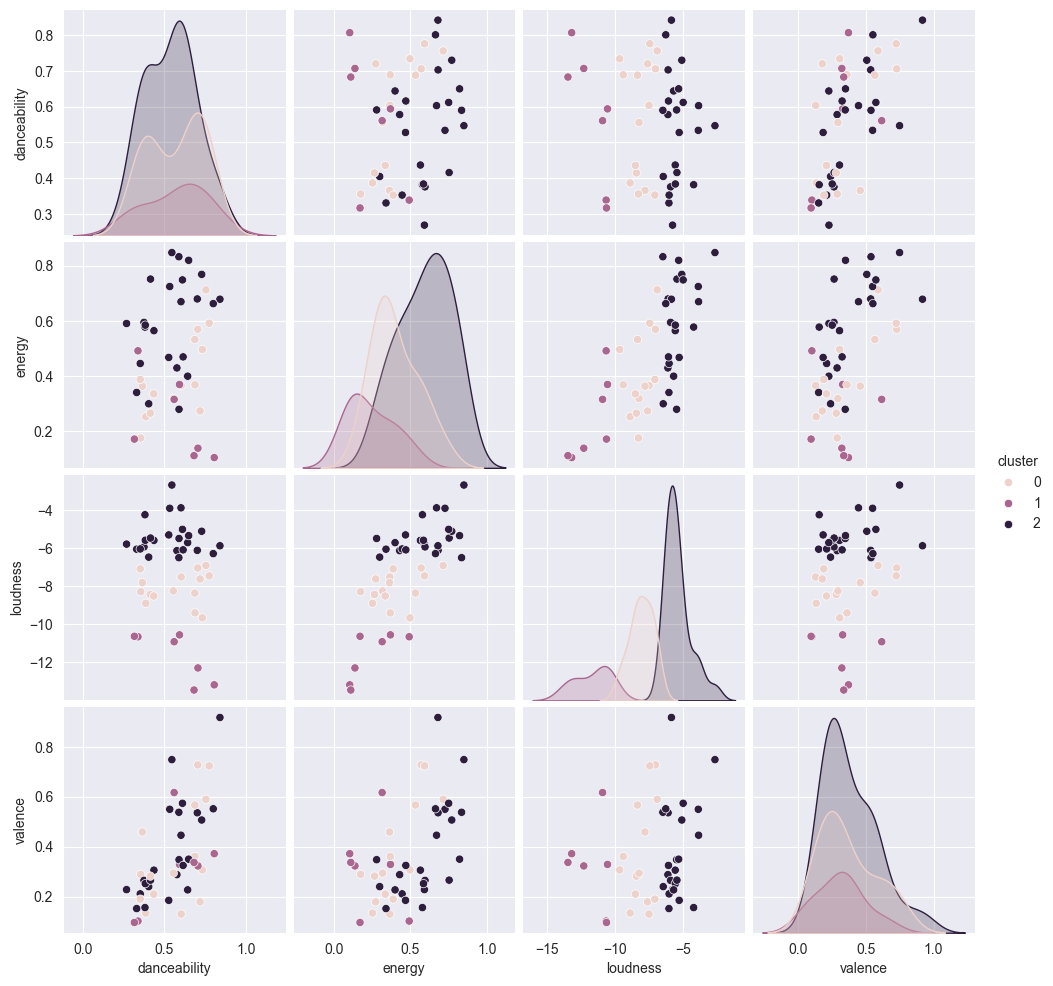

In [7]:
from sklearn.cluster import KMeans
import seaborn as sns

features = df[['danceability', 'energy', 'loudness', 'valence']]

kmeans = KMeans(n_clusters=3, random_state=0)
df['cluster'] = kmeans.fit_predict(features)

sns.pairplot(df, hue='cluster', vars=['danceability', 'energy', 'loudness', 'valence'])
plt.show()


### Distribution of Adele Songs by Key and Mode

In this section, we analyze the distribution of Adele's songs based on musical key and mode (major or minor).

- **Grouping by Key and Mode**: We group the dataset by the musical key and mode of each song and calculate the number of songs in each combination.
- **Handling Missing Data**: Any missing values in the resulting table are filled with zeros, ensuring a complete count for each key-mode combination.
- **Stacked Bar Chart**: We plot a stacked bar chart to visualize the distribution of songs, showing how many are in each key and whether they are in a major or minor mode.
- **Insight**: This analysis highlights which musical keys Adele frequently uses and whether her songs tend to be in major or minor modes.

This chart gives a clear picture of the diversity in key and mode across Adele's discography.


mode    0    1
key           
0     3.0  6.0
1     1.0  4.0
2     1.0  2.0
3     0.0  2.0
4     3.0  1.0
5     3.0  4.0
6     1.0  0.0
7     0.0  2.0
8     0.0  3.0
9     2.0  2.0
10    2.0  2.0
11    1.0  1.0


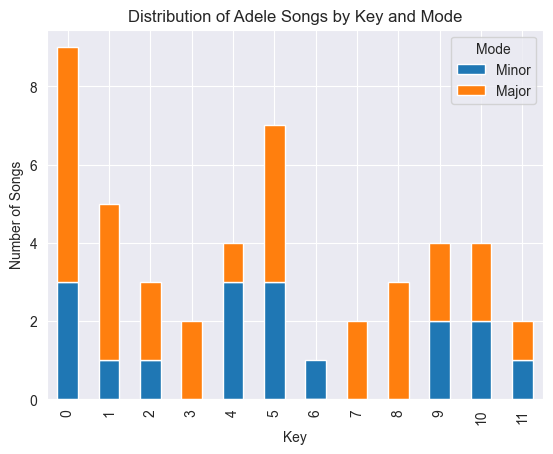

In [8]:
key_mode_count = df.groupby(['key', 'mode']).size().unstack().fillna(0)

print(key_mode_count)

key_mode_count.plot(kind='bar', stacked=True)
plt.title('Distribution of Adele Songs by Key and Mode')
plt.xlabel('Key')
plt.ylabel('Number of Songs')
plt.legend(['Minor', 'Major'], title='Mode')
plt.show()


### Heatmap of Correlation Matrix for Adele's Song Features

In this section, we visualize the correlation matrix of key audio features from Adele's songs using a heatmap.

- **Correlation Matrix**: We calculate the correlation matrix for five audio features—danceability, energy, popularity, loudness, and valence. This matrix shows how strongly these features are related to one another.
- **Heatmap Visualization**: A heatmap is used to visually represent the correlation values, where:
  - Positive correlations are shown in warm colors (red).
  - Negative correlations are shown in cool colors (blue).
  - The strength of the correlation is annotated in each cell.
  
- **Insight**: This heatmap helps us quickly identify which features have strong positive or negative correlations. For example, we can explore whether high-energy songs tend to be more popular or if there are any interesting relationships between valence and other features.

This visualization provides an intuitive understanding of the relationships between the audio features.


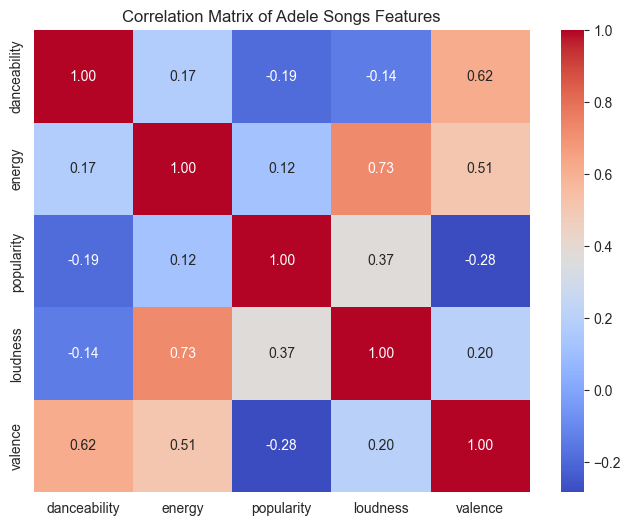

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df[['danceability', 'energy', 'popularity', 'loudness', 'valence']].corr()

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Adele Songs Features')
plt.show()

### Album Summary Analysis

The following code groups a DataFrame by `album_name` and calculates various aggregate statistics for the columns `popularity`, `energy`, and `danceability`. The aggregated statistics include:

- **popularity**: Mean, maximum, and minimum values.
- **energy**: Mean and standard deviation.
- **danceability**: Mean and standard deviation.

In [10]:
album_summary = df.groupby('album_name').agg({
    'popularity': ['mean', 'max', 'min'],
    'energy': ['mean', 'std'],
    'danceability': ['mean', 'std']
}).reset_index()

print(album_summary)

  album_name popularity            energy           danceability          
                   mean max min      mean       std         mean       std
0         19  46.250000  60  36  0.399333  0.246159     0.629083  0.179203
1         21  64.909091  81  52  0.534000  0.198788     0.580273  0.117910
2         25  66.090909  78  51  0.500091  0.191696     0.496455  0.139093
3         30  64.833333  82  58  0.482667  0.180077     0.506583  0.169626


### Track Details Finder

The following code defines a function `find_track_details` that retrieves and displays details about a track from a DataFrame based on the track's name. It then prompts the user to input a track name and displays the details for the specified track.



In [5]:
def find_track_details(track_name):
    track_info = df[df['track_name'].str.lower() == track_name.lower()]
    if not track_info.empty:
        for i, row in track_info.iterrows():
            print(f"Track Name: {row['track_name']}")
            print(f"Album Name: {row['album_name']}")
            print(f"Release Date: {row['release_date']}")
            print(f"Duration: {row['duration_minutes']} minutes")
            print(f"Popularity: {row['popularity']}")
            print(f"Track URL: {row['track_url']}")
            print("\n")
    else:
        print("Track not found.")

track = input("Please, input the name of the track: ")
find_track_details(track)

Track Name: Easy On Me
Album Name: 30
Release Date: 2021-11-19
Duration: 3 minutes
Popularity: 82
Track URL: https://open.spotify.com/track/46IZ0fSY2mpAiktS3KOqds


